# Assignment 8: Phân loại phương tiện giao thông - BOW &SVM

Tổng quan: Ở bài tập này chúng ta sẽ lần lượt thực hành các bước để xây dựng một hệ thống học máy cho bài toán phân loại phương tiện giao thông: khảo sát dữ liệu, trích xuất đặc trưng, xây dựng mô hình phân loại, phân loại trên hình ảnh thực tế. Bài tập yêu cầu các kiến thức về lập trình Python với các thư viện: OpenCV, scikit-learn, pickle, numpy.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import sklearn

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

## I: Khảo sát và chuẩn bị dữ liệu
Bộ dữ liệu được lưu ở thư mục con trainingset trong thư mục bài tập này. Thư mục trainingset bao gồm 5 thư mục con ứng với 5 nhãn của bài toán, trong mỗi thư mục con chứa ảnh tương ứng với nhãn. Với câu hỏi đầu tiên này chúng ta sẽ khảo sát những đặc điểm của bộ dữ liệu, hãy lập trình hoàn chỉnh các hàm theo các yêu cầu cụ thể sau đây:

### I.1: Quan sát một vài mẫu dữ liệu
Trước tiên ta sẽ quan sát một vài ví dụ về bộ dữ liệu. Hãy lập trình hàm load_image() nhận đầu vào là đường dẫn ảnh, trả về mảng numpy lưu trữ ảnh, sử dụng thư viện OpenCV. Câu hỏi này giúp bạn ôn tập cách thức load ảnh với OpenCV và hướng dẫn bạn những thao tác cơ bản với thư viện os. Hãy quan sát đoạn mã nguồn dưới đây:

In [2]:
def load_image(image_path):
    #### YOUR CODE HERE ####
    # load images và ra kết quả
   

    #### END YOUR CODE #####

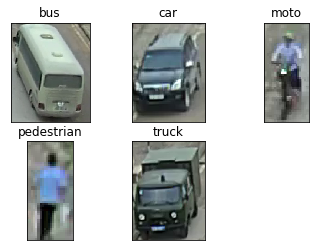

In [3]:
samples_list = []
samples_label = []
for label in os.listdir('trainingset',):
    sample_file = os.listdir(os.path.join('trainingset', label))[0]
    
    samples_list.append(load_image(os.path.join('trainingset', label, sample_file)))
    
    samples_label.append(label)
    
for i in range(len(samples_list)):
    plt.subplot(2, 3, i + 1), plt.imshow(cv2.cvtColor(samples_list[i], cv2.COLOR_BGR2RGB))
    plt.title(samples_label[i]), plt.xticks([]), plt.yticks([])
    
plt.show()

Một vài hàm hay sử dụng trong thư viện os (các hàm này các bạn đã được làm trong các bài thực hành trước đó):
- Hàm os.listdir(path): Trả về một list chứa tên các thư mục và file nằm trong thư mục path. Vì hàm trả về một list nên ta có thể tính được tổng số folder và file trong một thư mục (dùng hàm len())
- Hàm os.path.join(t1, t2, [t3, ...]): Trả về đường dẫn trong hệ điều hành tương ứng nối các đường dẫn t1, t2, t3,... Ví dụ ta có t1 = 'trainingset', t2 = 'image' thì hàm trả về xâu s = 'trainingset/image' với Ubuntu hoặc s = 'trainingset\\image' với Windows. 

### I.2: Thống kê dữ liệu
Hãy lập trình hàm statistic() để thống kê số lượng ảnh ứng với mỗi nhãn. Hàm statistic() cần trả về 2 danh sách (list): label, num_images. Danh sách label lưu tên các nhãn và danh sách num_images lưu số lượng ảnh tương ứng với nhãn lưu ở danh sách label.

In [4]:
def statistic():
    label = []
    num_images = []

    #### YOUR CODE HERE ####



    #### END YOUR CODE #####

    return label, num_images

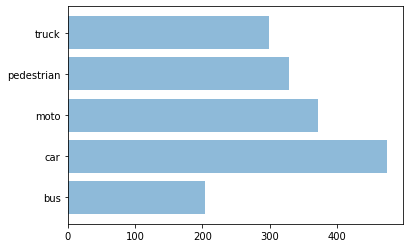

Total images: 1678


In [5]:
# lấy các nhãn và hiển thị số liệu mẫu với từng tập dữ liệu
label, num_images = statistic()

y_pos = np.arange(len(label))

plt.barh(y_pos, num_images, align='center', alpha=0.5)
plt.yticks(y_pos, label)
plt.show()

print('Total images: %d' %(sum(num_images)))

### I.3: Xây dựng danh sách chứa ảnh

Để tiện cho việc lập trình các bước tiếp theo ta sẽ xây dựng một list lưu trữ ảnh và nhãn tương ứng của nó. Hãy lập trình hàm read_data(), hàm này trả về hai list X, Y, trong đó mỗi phần tử của list X lưu trữ một mảng numpy biểu diễn một ảnh và mỗi phần tử của list Y lưu trữ nhãn (dưới dạng số nguyên) tương ứng của ảnh.

In [6]:
def read_data(label2id):
    X = []
    Y = []

    for label in os.listdir('trainingset'):
        for img_file in os.listdir(os.path.join('trainingset', label)):
            #### YOUR CODE HERE ####
            
            
            #### END YOUR CODE #####
            
            X.append(img)
            Y.append(label2id[label])
    return X, Y

In [7]:
# Label to id, used to convert string label to integer 
label2id = {'pedestrian':0, 'moto':1, 'truck':2, 'car':3, 'bus':4}
X, Y = read_data(label2id)
print(len(X))
print(len(Y))
for i in range(10):
    print(X[i].shape)
    print(Y[i])

1678
1678
(168, 134, 3)
4
(270, 193, 3)
4
(168, 120, 3)
4
(107, 83, 3)
4
(97, 80, 3)
4
(39, 34, 3)
4
(182, 139, 3)
4
(53, 35, 3)
4
(98, 66, 3)
4
(174, 119, 3)
4


## II: Biểu diễn nội dung bức ảnh - trích xuất đặc trưng (features extraction)

Ở phần này chúng ta sẽ lần lượt thực hiện các công việc: trích xuất đặc trưng SIFT (SIFT keypoints descriptor), xây dựng từ điển và mô hình Bag-of-Word (BoW). Bạn hãy lập trình hoàn chỉnh các hàm theo yêu cầu cụ thể dưới đây

### II.1: Trích xuất đặc trưng SIFT

Hãy lập trình hàm extract_sift_features() nhận đầu vào là list ảnh ta đã xây dựng được từ câu hỏi trước và trả về:
- list image_descriptors, 
- phần tử thứ p trong list image_descriptors lại là một list chứa các SIFT descriptors ứng với ảnh thứ p trong list X.

Gợi ý: 
- Để khởi tạo đối tượng SIFT trong OpenCV ta sử dụng lệnh: sift = cv2.xfeatures2d.SIFT_create() hoặc cv2.SIFT_create() tùy version. 
- Đối tượng này có phương thức detectAndCompute trả về 2 outputs kp và des, kp là một list chứa các keypoints được detect bởi SIFT, des là một numpy array chứa len(kp) vectors 128 chiều. 

In [8]:
def extract_sift_features(X):
    image_descriptors = []
    sift = cv2.xfeatures2d.SIFT_create()

    for i in range(len(X)):
        #### YOUR CODE HERE ####

        
        #### END YOUR CODE #####

    return image_descriptors

In [9]:
image_descriptors = extract_sift_features(X)
print(len(image_descriptors))
print(type(image_descriptors[0][0]))
for i in range(10):
    print('Image {} has {} descriptors'.format(i, len(image_descriptors[i])))

1678
<class 'numpy.ndarray'>
Image 0 has 109 descriptors
Image 1 has 148 descriptors
Image 2 has 59 descriptors
Image 3 has 29 descriptors
Image 4 has 83 descriptors
Image 5 has 28 descriptors
Image 6 has 219 descriptors
Image 7 has 22 descriptors
Image 8 has 62 descriptors
Image 9 has 181 descriptors


### II.2: Xây dựng từ điển
Hãy lập trình hàm kmeans_bow():
- input: list gồm tất cả các descriptors của các ảnh trong tập X và số cụm num_clusters. Có thể sử dụng thuật toán KMeans trong scikit-learn phân cụm các vector descriptors này thành num_clusters cụm
- output: danh sách tâm của các cụm. Danh sách tâm cụm này chính là tương ứng với từ điển (hay tập các từ trực quan). 

Lưu ý: 
- Từ điển là danh sách tham chiếu đến khi biểu diễn nên cần lưu lại
- Quá trình xây dựng cũng tiêu tốn thời gian nên chúng ta chỉ xây dựng lại từ điển khi cần thiết. 
==> Từ điển xây dựng xong cần lưu ra một file nhị phân (sử dụng thư viện pickle) để tiện sử dụng sau này.

In [10]:
#Trước tiên ta sẽ xây dựng một list chứa tất cả các descriptors từ tập ảnh ban đầu (tập ảnh tham chiếu, tập dữ liệu mẫu)
all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)
print('Total number of descriptors: %d' %(len(all_descriptors)))

Total number of descriptors: 155508


In [11]:
# Hãy lập trình hàm kmeans_bow().

# Gợi ý: Trong thư viện sklearn, để khởi tạo một đối tượng kmeans ta sử dụng lệnh:
#       kmeans = sklearn.cluster.KMeans(n_clusters=num_clusters)

#       kmeans có phương thức fit, nhận vào các điểm dữ liệu (trong bài toán hiện tại của chúng ta là list all_descriptors) 
#              và tìm ra n_clusters vector là tâm của các cụm dữ liệu. 
#              Để lấy được các vector này ta sử dụng thuộc tính $cluster_centers_$  của đối tượng kmeans
import time

def kmeans_bow(all_descriptors, num_clusters):
    start = time.time()
    
    bow_dict = []

    #### YOUR CODE HERE ####



    #### END YOUR CODE #####
    
    print('Process time: ', time.time() - start)

    return bow_dict

In [ ]:
# Thực hiện phân cụm để xây dựng từ điển và lưu ra 1 file 
num_clusters = 50
if not os.path.isfile('bow_dictionary4.pkl'):
    BoW = kmeans_bow(all_descriptors, num_clusters)
    pickle.dump(BoW, open('bow_dictionary.pkl', 'wb'))
else:
    BoW = pickle.load(open('bow_dictionary.pkl', 'rb'))
    # BoW = pickle.load(open('bow_dictionary.pkl', 'rb'), encoding='latin1')
    
print(len(BoW))
print(type(BoW[0]))

### II.3: Xây dựng vector đặc trưng với mô hình BoW

Hãy xây dựng hàm create_features_bow():
- input: list image_descriptors, list chứa các từ trực quan (tâm cụm) và số từ (num_clusters) ở trên, 
- output: trả về list X_features, X_features[p] là vector biểu diễn theo mô hình BOW ứng với ảnh thứ p: tần suất xuất hiện của từ. Hãy chú ý sự tương ứng các phần tử trong 4 danh sách: X, Y, image_descriptors, X_features.

In [33]:
from scipy.spatial.distance import cdist

In [34]:
def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_clusters)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)
            #### YOUR CODE HERE ####

            #### END YOUR CODE #####

        X_features.append(features)


    return X_features

In [35]:
print(image_descriptors[0].shape)
print(BoW[0].shape)
X_features = create_features_bow(image_descriptors, BoW, num_clusters)
print(len(X_features))
print(X_features[0])
print(sum(X_features[0]))
print(image_descriptors[0].shape[0])

(109, 128)
(128,)
1678
[ 0  1  0  4  3  2  0  1  0  1  3  1  2  2  2  3  1  4  5  2  1  3 10  2
  0  0  2  5  1  4  2  2  0  4  1  2  2  1  9  2  1  1  1  5  1  2  1  2
  5  0]
109
109


## III: Xây dựng mô hình phân loại
Từ các câu hỏi trước chúng ta đã xây dựng được vector đặc trưng ứng với mỗi ảnh trong bộ dữ liệu. Ở câu hỏi này chúng ta sẽ xây dựng các mô hình phân loại SVM

In [36]:
print(len(X_features))
print(len(Y))

1678
1678


Chia tập dữ liệu thành tập train/test:

In [192]:
from sklearn.model_selection import train_test_split

X_train = [] 
X_test = []
Y_train = []
Y_test = []
#### YOUR CODE HERE #### 
X_train, X_test, Y_train, Y_test = ..............
id_train, id_test = ............# Tạo ra id để track ngược lại image từ feature
#### END YOUR CODE ####
print(len(X_train))
print(len(X_test))

1342
336


Khai báo đối tượng SVM:

In [62]:
svm = sklearn.svm.SVC(C = 30)
print(svm)

SVC(C=30)


Huấn luyện, kiểm tra độ chính xác của mô hình tương tự như các bài học trước (sử dụng các hàm fit, predict, score,... của đối tượng svm)

Huấn luyện mô hình:

In [63]:
svm.fit(X_train, Y_train)

SVC(C=30)

Tính độ chính xác trên tập dữ liệu huấn luyện:

In [165]:
svm.score(X_train, Y_train)

0.96274217585693

Tính độ chính xác trên tập dữ liệu test:

In [166]:
svm.score(X_test, Y_test)

0.7202380952380952

Vẽ confusion matrix kết quả dự đoán trên tập test và in accuracy của từng nhãn lớp.

              precision    recall  f1-score   support

  pedestrian      0.785     0.873     0.827        71
        moto      0.744     0.803     0.772        76
       truck      0.544     0.705     0.614        44
         car      0.798     0.676     0.732       105
         bus      0.586     0.425     0.493        40

    accuracy                          0.720       336
   macro avg      0.691     0.696     0.687       336
weighted avg      0.724     0.720     0.717       336



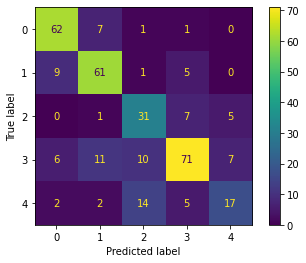

In [177]:
from sklearn.metrics import plot_confusion_matrix, classification_report

Y_predict = svm.predict(X_test)

plot_confusion_matrix(svm, X_test, Y_test)
print(classification_report(Y_test, Y_predict, digits=3, target_names=list(label2id.keys())))

Một vài kết quả dự đoán trên tập test.

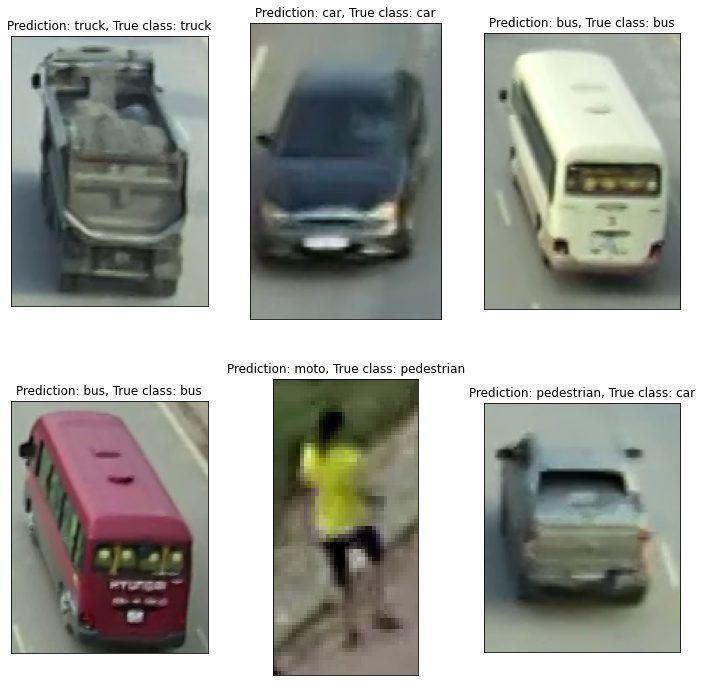

In [202]:
# Một vài kết quả dự đoán trên tập test
#### YOUR CODE HERE #### 


#### YOUR CODE HERE #### 

## IV: Dùng mô hình đã huấn luyện dự đoán hình ảnh thực tế

Cuối cùng ta sẽ dùng thử mô hình đã huấn luyện để đưa ra dự đoán về một hình ảnh thực tế. Chúng ta sẽ làm lần lượt các bước: đọc ảnh, trích xuất đặc trưng BoW của ảnh, dự đoán sử dụng mô hình đã huấn luyện.

__Bước 1__: Đọc ảnh ở đường dẫn image_test/car.png, lưu ảnh vào biến img

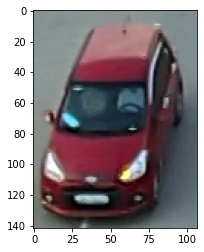

(142, 107, 3)


In [45]:
img = None

img = load_image('image_test/car.png')

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

print(img.shape)
my_X = [img]

__Bước 2__: Trích xuất đặc trưng SIFT (lưu vào biến my_image_descriptors) và BoW (lưu vào biến my_X_features) từ my_X:

In [46]:
my_image_descriptors = None
my_X_features = None

#### YOUR CODE HERE ####


#### END YOUR CODE #####

print(len(my_image_descriptors[0]))
print(my_X_features[0].shape)

106
(50,)


__Bước 3:__ Sử dụng mô hình đã huấn luyện để dự đoán, kết quả dự đoán lưu vào biến my_y_pred

In [24]:
y_pred = None

#### YOUR CODE HERE ####

y_pred = ...
#### END YOUR CODE #####

print(y_pred)
print(label2id)
# Get your label name using label2id variable (define above)
for key, value in label2id.items():
    if value == y_pred[0]:
        print('Your prediction: ', key)

[3]
{'pedestrian': 0, 'moto': 1, 'truck': 2, 'car': 3, 'bus': 4}
Your prediction:  car


## Sử dụng với HOG cho biểu diễn nội dung ảnh cho bài toán nhận dạng